<a href="https://colab.research.google.com/github/zhuowenzhao/ANN_feature_evaluation/blob/master/2_4_ML_tutorial_dataLoading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
import glob
import torch
from torchvision import datasets, transforms
from PIL import Image

# 2.4 Pytorch dataset and dataloader
In section 2.1, we learned how to load images and convert them to PyTorch Tensor Dataset. In this section, we will learn how to create training and validation Pytorch datasets that have `(data, label)` structure such that they can be used for supervised training. We will also learn to load these datasets in batches (avoid memory overflow) using a dataloader.

DataLoader has a few more advantages:
1. Shuffle data
2. Multiprocess loading

## 2.4.1 Create image dataset from directory

We can use `torchvision.datasets.ImageFolder` to  create an image dataset from directory. Note that, in order to use this function, the directory must contain subdirectories for each label/category.

In the example below, we are loading a dataset stored like this:  
```
data
  images
    000001.jpg
    000002.jpg
    ...
```

In [ ]:
# image processing
input_size = 64 # square image size
process = transforms.Compose([transforms.Resize(input_size),
                              transforms.CenterCrop(input_size),
                              transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                           ])

In [248]:


# Create the dataset
dataset = datasets.ImageFolder(root='data',
                               transform=process)

# each subdir is labeled as 0,1,...
print(len(dataset))
print(next(iter(dataset)))  # get the first image and its label

# for data, label in dataset:
#   print(label, data)

400
(tensor([[[-0.5608, -0.5529, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5451, -0.5451,  ..., -0.5843, -0.5843, -0.5922],
         [-0.5451, -0.5373, -0.5294,  ..., -0.5765, -0.5765, -0.5843],
         ...,
         [-0.0275,  0.0510,  0.0980,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0745,  0.0039,  0.0667,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0980, -0.0588,  0.0353,  ..., -0.3961, -0.3961, -0.3961]],

        [[-0.5608, -0.5529, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5451, -0.5451,  ..., -0.5843, -0.5843, -0.5922],
         [-0.5451, -0.5373, -0.5294,  ..., -0.5765, -0.5765, -0.5843],
         ...,
         [-0.0275,  0.0510,  0.0980,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0745,  0.0039,  0.0667,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0980, -0.0588,  0.0353,  ..., -0.3961, -0.3961, -0.3961]],

        [[-0.5608, -0.5529, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5451, -0.5451,  ..

## 2.4.2 Create customized image dataset

We can also create a customized dataset using `torch.utils.data.Dataset` which is an abstract class representing a dataset. In the example below, we are loading a dataset stored like this:  
```
images
  000001.jpg
  000002.jpg
  ...
```

In [249]:
# create customized dataset class
class myDataset(torch.utils.data.Dataset):
    '''
    Args:
        folder      str, folder path
        format      str, formats supported by PIL
        label       int, default 0
        transform   callable

    Return:
        tensor dataset  tuple, (image, label)
    '''
    # overwrite the constructer (More complicated class inheritance use super(), e.g., nn.Module)
    def __init__(self, root=None, format=None, label=None, transform=None):  
        _file_path = root+'/*.'+format if format else root+'/*'
        self.dataset = glob.glob(_file_path) #filenmae matching
        self.label = label if label else 0
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if self.transform:
            return self.transform(Image.open(data)), self.label
        else:
            return Image.open(data), self.label


In [250]:
dataset = myDataset(root='images', 
                    transform=process)  
print(next(iter(dataset)))

(tensor([[[ 0.0353,  0.0353,  0.0275,  ...,  0.3725,  0.3098,  0.2471],
         [ 0.0196,  0.0196,  0.0118,  ...,  0.4353,  0.3804,  0.3255],
         [ 0.0039,  0.0118,  0.0118,  ...,  0.4980,  0.4510,  0.3961],
         ...,
         [-0.0980, -0.0510,  0.0196,  ..., -0.3725, -0.3647, -0.3804],
         [-0.1529, -0.1137, -0.0667,  ..., -0.3804, -0.3725, -0.3725],
         [-0.1922, -0.1686, -0.1294,  ..., -0.3804, -0.3804, -0.3804]]]), 0)


## 2.4.3 Create datasets for training, validation, and testing

You can create these datasets separtely or you can use `torch.utils.data.random_split` to split the dataset.

In [251]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])
print(len(train_dataset), len(val_dataset), len(test_dataset))


240 80 80


## 2.4.4 Load data in batches

In [252]:
# Create the dataloader
batch_size = 16
workers = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=workers,
                                               drop_last=False,
                                               prefetch_factor=2)

print(len(train_dataloader))
print(next(iter(train_dataloader)))

15
[tensor([[[[ 0.2000,  0.0196,  0.0039,  ...,  0.3961,  0.3490,  0.1765],
          [-0.0588, -0.0745, -0.0667,  ...,  0.0902,  0.0980,  0.0588],
          [-0.0510,  0.0196, -0.0510,  ..., -0.0902, -0.0980, -0.0902],
          ...,
          [-0.8118, -0.8118, -0.8118,  ..., -0.8118, -0.8118, -0.8196],
          [-0.8118, -0.8118, -0.8118,  ..., -0.8118, -0.8196, -0.8118],
          [-0.8196, -0.8118, -0.8118,  ..., -0.8118, -0.8196, -0.8118]]],


        [[[-0.6314, -0.6392, -0.6471,  ..., -0.6314, -0.6314, -0.6471],
          [-0.6314, -0.6549, -0.6627,  ..., -0.6392, -0.6392, -0.6392],
          [-0.6471, -0.6392, -0.6471,  ..., -0.6314, -0.6314, -0.6235],
          ...,
          [-0.5608, -0.5529, -0.5529,  ..., -0.5294, -0.5294, -0.5137],
          [-0.5608, -0.5529, -0.5451,  ..., -0.5294, -0.5451, -0.5608],
          [-0.5765, -0.5843, -0.5843,  ..., -0.5608, -0.5373, -0.5294]]],


        [[[ 0.3569,  0.3882,  0.4118,  ...,  0.3020,  0.2784,  0.2549],
          [ 0.4039,  0

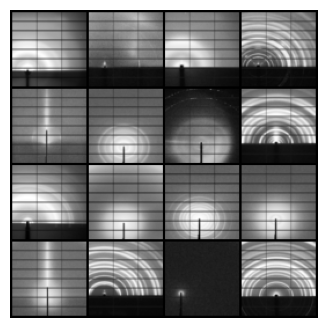

In [253]:
# plot batch images

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(next(iter(train_dataloader))[0], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))